# Z Co-activation numeric integration

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect
from plotting_functions import plot_weight_matrix, plot_state_variables_vs_time, plot_winning_pattern
from plotting_functions import plot_network_activity, plot_network_activity_angle
from analysis_functions import calculate_recall_time_quantities, calculate_angle_from_history, get_weights
from connectivity_functions import artificial_connectivity_matrix

## Piece-wise functions
First let's define the piece wise functions

In [2]:
def climb(t, tau_z, T1, T2):
    return (1 - np.exp(-(t - T1) / tau_z))
def descend(t, tau_z, T1, T2):
    return (1 - np.exp(-(T2 - T1) / tau_z)) * np.exp(-(t - T2)/tau_z)

In [3]:
def z_trace_aux(t, tau_z, T1, T2):
    if t < T1:
        z = 0
    elif t > T1 and t < T2:
        z = (1 - np.exp(-(t - T1)/ tau_z))
    elif t > T2:
        z = (1 - np.exp(-(T2 - T1) / tau_z)) * np.exp(-(t - T2) / tau_z)
    return z

In [4]:
tau_z = 0.050 
T1 = 0.100
T2 = 0.200
time = np.linspace(0, 1, num=10000)
max_value = (1 - np.exp(-(T2 - T1) / tau_z))

In [5]:
z_aux = []
for t in time:
    z_aux.append(z_trace_aux(t, tau_z, T1, T2))
    
z_aux = np.array(z_aux)

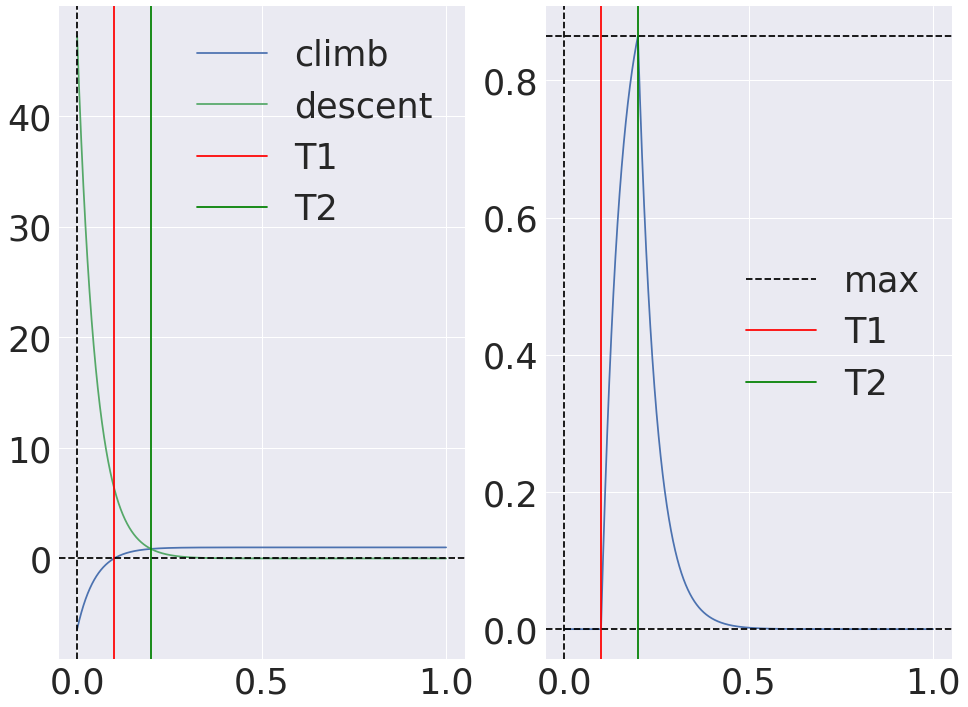

In [6]:
z1 = climb(time, tau_z, T1, T2)
z2 = descend(time, tau_z, T1, T2)
t = time

z_pre = np.piecewise(t, [np.logical_and(t < T2, t>T1), t >=T2 ], [climb, descend, 0], T1=T1, T2=T2, tau_z=tau_z)

fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(121)
ax1.plot(time, z1, label='climb')
ax1.plot(time, z2, label='descent')


ax2 = fig.add_subplot(122)
ax2.plot(time, z_aux)
ax2.axhline(max_value, ls='--', color='black', label='max')

ax1.axvline(T1, ls='-', color='red', label='T1')
ax1.axvline(T2, ls='-', color='green', label='T2')

ax2.axvline(T1, ls='-', color='red', label='T1')
ax2.axvline(T2, ls='-', color='green', label='T2')

ax1.axhline(0, ls='--', color='black')
ax2.axhline(0, ls='--', color='black')

ax1.axvline(0, ls='--', color='black')
ax2.axvline(0, ls='--', color='black');

ax1.legend();
ax2.legend();

Now let's define a piece wise funcition

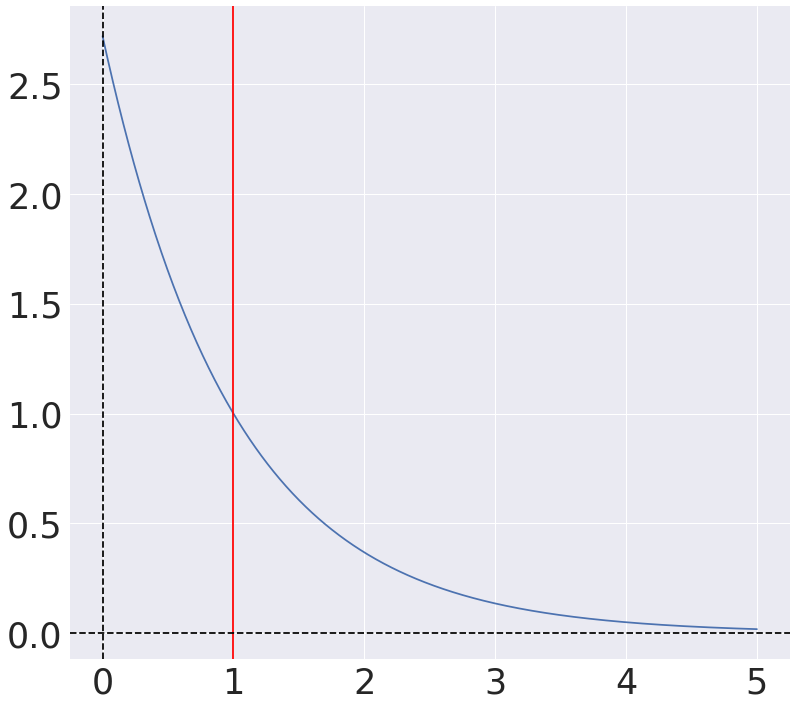

In [7]:
A = 1.0
x = np.linspace(0, 5.0, num=1000)
y = np.exp(-(x - A))
plt.plot(x, y)
plt.axvline(A, color='red')
plt.axvline(0, ls='--', color='black')
plt.axhline(0, ls='--', color='black');

#### Clean function and some examples

In [8]:
def z_trace(time, tau_z, T1, T2):
    
    z_vector = []
    for t in time:
        if t < T1:
            z = 0
        elif t > T1 and t < T2:
            z = (1 - np.exp(-(t - T1)/ tau_z))
        elif t > T2:
            z = (1 - np.exp(-(T2 - T1) / tau_z)) * np.exp(-(t - T2) / tau_z)
        z_vector.append(z)
        
    return np.array(z_vector)

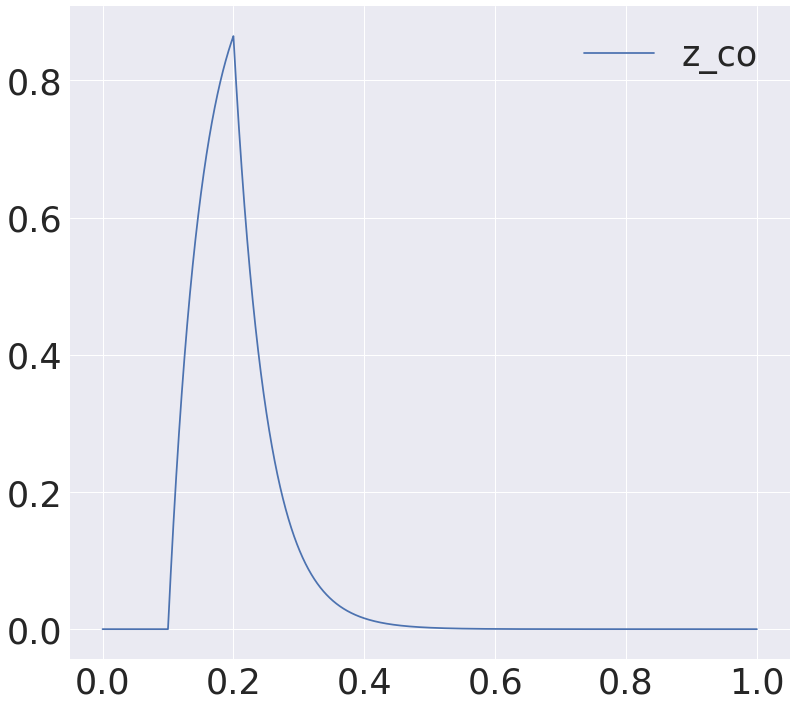

In [9]:
tau_z = 0.050 
T1 = 0.100
T2 = 0.200
time = np.linspace(0, 1, num=10000)
z_co = z_trace(time, tau_z, T1, T2)

plt.plot(time, z_co, label='z_co')
plt.legend();

Now let's do an example with two z_traces with different time constans

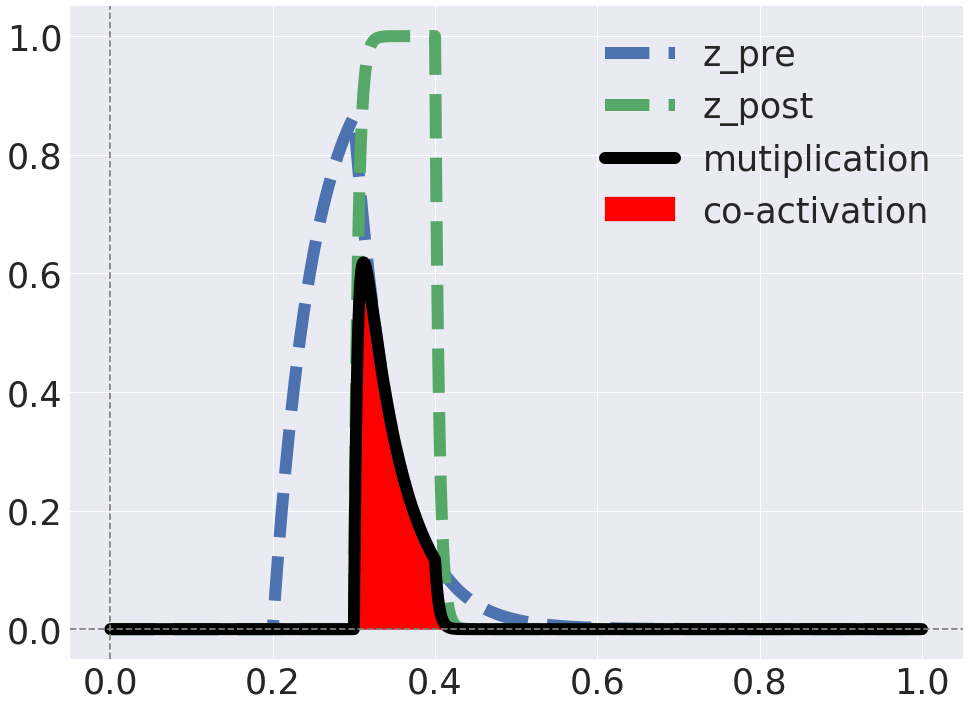

In [10]:
tau_z_pre = 0.050 
tau_z_post = 0.005
training_time = 0.100
time = np.linspace(0, 1, num=10000)
z_pre = z_trace(time, tau_z_pre, 2*training_time, 3*training_time)
z_post = z_trace(time, tau_z_post, 3*training_time, 4*training_time)
z_co = z_pre * z_post

linewidth = 12

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.plot(time, z_pre, ls='--', linewidth=linewidth, label='z_pre')
ax.plot(time, z_post, ls='--', linewidth=linewidth, label='z_post')
ax.plot(time, z_co, linewidth=linewidth, color='black', label='mutiplication')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.fill_between(time, z_co, 0, color='red', label='co-activation')

ax.legend();

Let's do an integration of an expression that is close to 1 * 0.100 = 0.100

integral 0.0999997510273
should be = 0.1


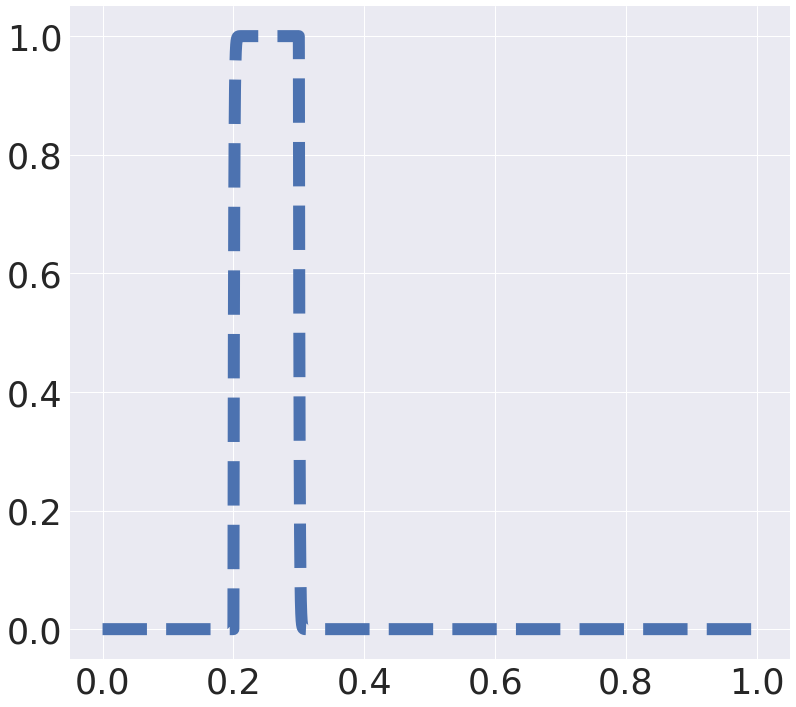

In [11]:
tau_z_pre = 0.001 
training_time = 0.100
time = np.linspace(0, 1, num=10000)
z_pre = z_trace(time, tau_z_pre, 2*training_time, 3*training_time)

integral = np.trapz(z_pre, time)
print('integral', integral)
print('should be =', 1.0 * 0.100)

plt.plot(time, z_pre, ls='--', linewidth=linewidth, label='z_pre');

## self-co-activation

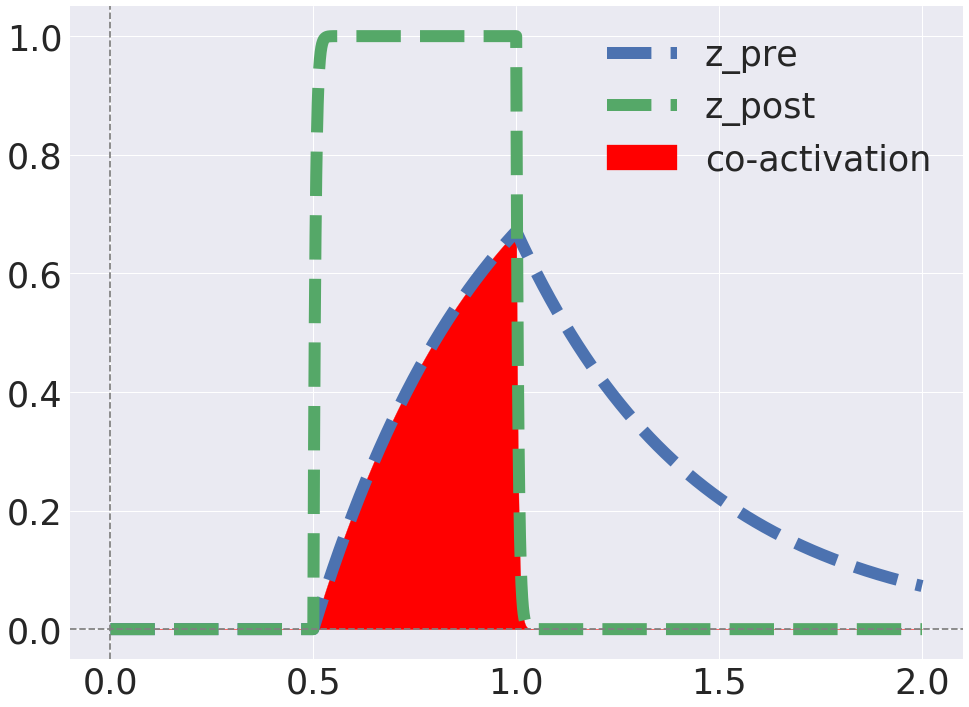

In [12]:
tau_z_pre = 0.450 
tau_z_post = 0.005
training_time = 0.500
T_total = training_time * 4
time = np.linspace(0, T_total, num=10000)
z_pre = z_trace(time, tau_z_pre, training_time, 2*training_time)
z_post = z_trace(time, tau_z_post, training_time, 2*training_time)
z_co = z_pre * z_post

linewidth = 12

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.plot(time, z_pre, ls='--', linewidth=linewidth, label='z_pre')
ax.plot(time, z_post, ls='--', linewidth=linewidth, label='z_post')
# ax.plot(time, z_co, linewidth=linewidth, color='black', label='mutiplication')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.fill_between(time, z_co, 0, color='red', label='co-activation')

ax.legend();

#### Systematically

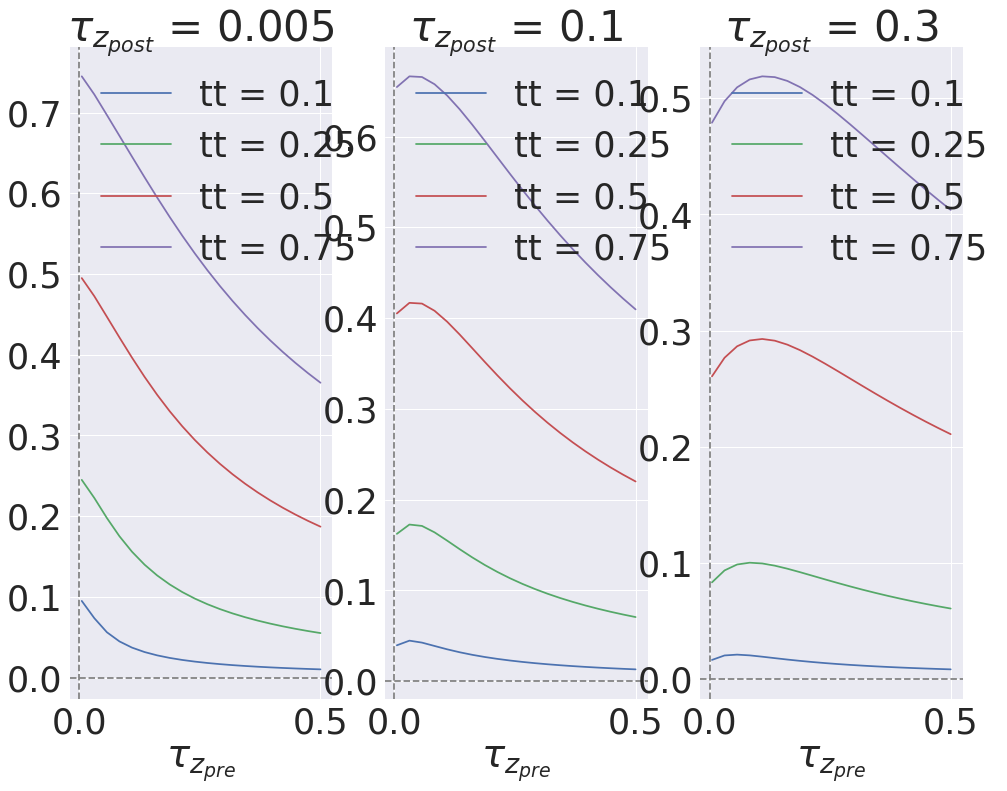

In [13]:
linewidth = 12
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

training_times = [0.100, 0.250, 0.500, 0.750]
integrals_list = []
tau_z_post = 0.005

for training_time in training_times:
    T_total = training_time * 4
    time = np.linspace(0, T_total, num=10000)
    tau_z_pre_vector = np.linspace(0.005, 0.500, num=20)
    integrals = []

    for tau_z_pre in tau_z_pre_vector:  
        z_pre = z_trace(time, tau_z_pre, training_time, 2*training_time)
        z_post = z_trace(time, tau_z_post, training_time, 2*training_time)
        z_co = z_pre * z_post

        integral = np.trapz(z_co, time)
        integrals.append(integral)
    
    integrals_list.append(integrals)
    
for integrals, training_time in zip(integrals_list, training_times):
    ax1.plot(tau_z_pre_vector, integrals, label='tt = ' + str(training_time))

ax1.set_title(r'$\tau_{z_{post}}$ = ' + str(tau_z_post))
ax1.set_xlabel(r'$\tau_{z_{pre}}$')
ax1.legend()
ax1.axhline(0, ls='--', color='gray')
ax1.axvline(0, ls='--', color='gray')

training_times = [0.100, 0.250, 0.500, 0.750]
integrals_list = []
tau_z_post = 0.100

for training_time in training_times:
    T_total = training_time * 4
    time = np.linspace(0, T_total, num=10000)
    tau_z_pre_vector = np.linspace(0.005, 0.500, num=20)
    integrals = []

    for tau_z_pre in tau_z_pre_vector:  
        z_pre = z_trace(time, tau_z_pre, training_time, 2*training_time)
        z_post = z_trace(time, tau_z_post, training_time, 2*training_time)
        z_co = z_pre * z_post

        integral = np.trapz(z_co, time)
        integrals.append(integral)
    
    integrals_list.append(integrals)
    
for integrals, training_time in zip(integrals_list, training_times):
    ax2.plot(tau_z_pre_vector, integrals, label='tt = ' + str(training_time))

ax2.set_title(r'$\tau_{z_{post}}$ = ' + str(tau_z_post))
ax2.set_xlabel(r'$\tau_{z_{pre}}$')
ax2.legend()
ax2.axhline(0, ls='--', color='gray')
ax2.axvline(0, ls='--', color='gray')

training_times = [0.100, 0.250, 0.500, 0.750, 1.0, 1.250, 1.500]
integrals_list = []
tau_z_post = 0.300

for training_time in training_times:
    T_total = training_time * 4
    time = np.linspace(0, T_total, num=10000)
    tau_z_pre_vector = np.linspace(0.005, 0.500, num=20)
    integrals = []

    for tau_z_pre in tau_z_pre_vector:  
        z_pre = z_trace(time, tau_z_pre, training_time, 2*training_time)
        z_post = z_trace(time, tau_z_post, training_time, 2*training_time)
        z_co = z_pre * z_post

        integral = np.trapz(z_co, time)
        integrals.append(integral)
    
    integrals_list.append(integrals)
    
for integrals, training_time in zip(integrals_list, training_times):
    ax3.plot(tau_z_pre_vector, integrals, label='tt = ' + str(training_time))

ax3.set_title(r'$\tau_{z_{post}}$ = ' + str(tau_z_post))
ax3.set_xlabel(r'$\tau_{z_{pre}}$')
ax3.legend()
ax3.axhline(0, ls='--', color='gray')
ax3.axvline(0, ls='--', color='gray')

#### Next

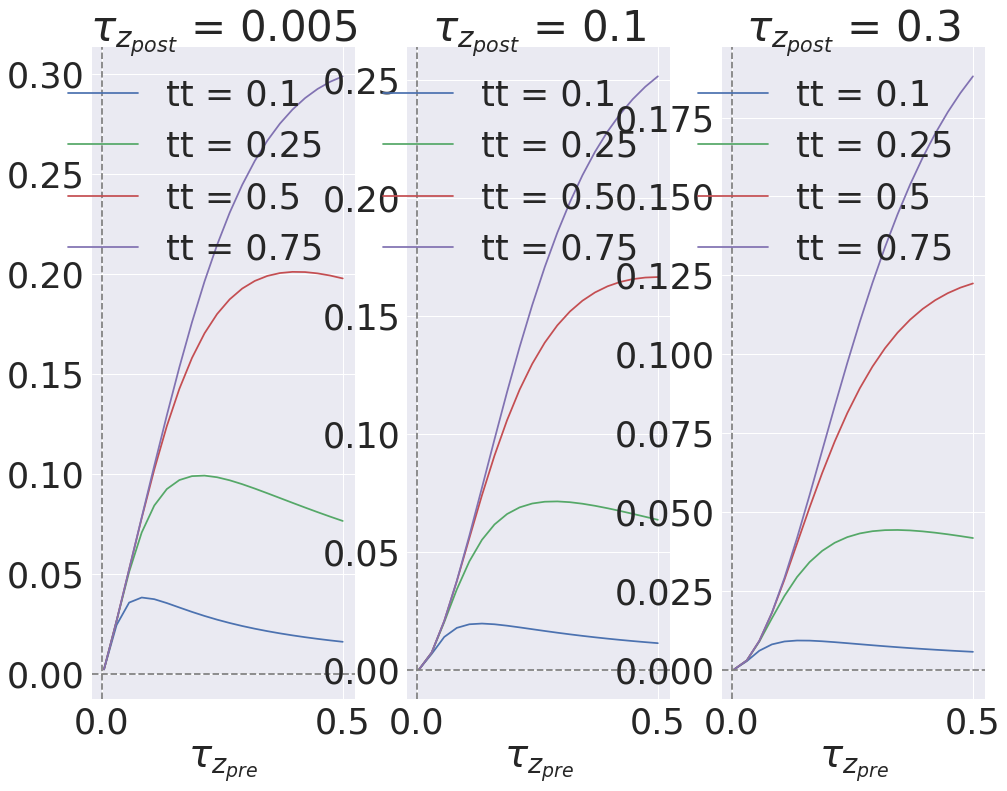

In [14]:
linewidth = 12
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

training_times = [0.100, 0.250, 0.500, 0.750]
integrals_list = []
tau_z_post = 0.005

for training_time in training_times:
    T_total = training_time * 4
    time = np.linspace(0, T_total, num=10000)
    tau_z_pre_vector = np.linspace(0.005, 0.500, num=20)
    integrals = []

    for tau_z_pre in tau_z_pre_vector:  
        z_pre = z_trace(time, tau_z_pre, training_time, 2*training_time)
        z_post = z_trace(time, tau_z_post, 2*training_time, 3*training_time)
        z_co = z_pre * z_post

        integral = np.trapz(z_co, time)
        integrals.append(integral)
    
    integrals_list.append(integrals)
    
for integrals, training_time in zip(integrals_list, training_times):
    ax1.plot(tau_z_pre_vector, integrals, label='tt = ' + str(training_time))

ax1.set_title(r'$\tau_{z_{post}}$ = ' + str(tau_z_post))
ax1.set_xlabel(r'$\tau_{z_{pre}}$')
ax1.legend()
ax1.axhline(0, ls='--', color='gray')
ax1.axvline(0, ls='--', color='gray')

training_times = [0.100, 0.250, 0.500, 0.750]
integrals_list = []
tau_z_post = 0.100

for training_time in training_times:
    T_total = training_time * 4
    time = np.linspace(0, T_total, num=10000)
    tau_z_pre_vector = np.linspace(0.005, 0.500, num=20)
    integrals = []

    for tau_z_pre in tau_z_pre_vector:  
        z_pre = z_trace(time, tau_z_pre, training_time, 2*training_time)
        z_post = z_trace(time, tau_z_post, 2*training_time, 3*training_time)
        z_co = z_pre * z_post

        integral = np.trapz(z_co, time)
        integrals.append(integral)
    
    integrals_list.append(integrals)
    
for integrals, training_time in zip(integrals_list, training_times):
    ax2.plot(tau_z_pre_vector, integrals, label='tt = ' + str(training_time))

ax2.set_title(r'$\tau_{z_{post}}$ = ' + str(tau_z_post))
ax2.set_xlabel(r'$\tau_{z_{pre}}$')
ax2.legend()
ax2.axhline(0, ls='--', color='gray')
ax2.axvline(0, ls='--', color='gray')

training_times = [0.100, 0.250, 0.500, 0.750]
integrals_list = []
tau_z_post = 0.300

for training_time in training_times:
    T_total = training_time * 4
    time = np.linspace(0, T_total, num=10000)
    tau_z_pre_vector = np.linspace(0.005, 0.500, num=20)
    integrals = []

    for tau_z_pre in tau_z_pre_vector:  
        z_pre = z_trace(time, tau_z_pre, training_time, 2*training_time)
        z_post = z_trace(time, tau_z_post, 2*training_time, 3*training_time)
        z_co = z_pre * z_post

        integral = np.trapz(z_co, time)
        integrals.append(integral)
    
    integrals_list.append(integrals)
    
for integrals, training_time in zip(integrals_list, training_times):
    ax3.plot(tau_z_pre_vector, integrals, label='tt = ' + str(training_time))

ax3.set_title(r'$\tau_{z_{post}}$ = ' + str(tau_z_post))
ax3.set_xlabel(r'$\tau_{z_{pre}}$')
ax3.legend()
ax3.axhline(0, ls='--', color='gray')
ax3.axvline(0, ls='--', color='gray');

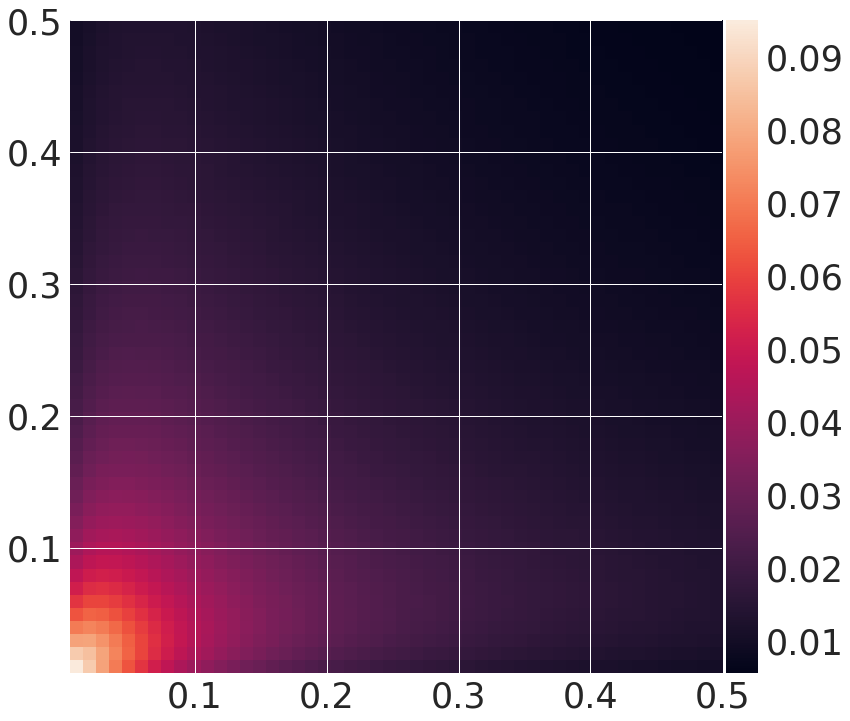

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

num = 50
tau_z_vector = np.linspace(0.005, 0.500, num=num)

training_time = 0.100
T_total = training_time * 4
time = np.linspace(0, T_total, num=10000)

integrals = np.zeros((num, num))

for index1, tau_z_pre in enumerate(tau_z_vector):
    for index2, tau_z_post in enumerate(tau_z_vector):

        z_pre = z_trace(time, tau_z_pre, training_time, 2*training_time)
        z_post = z_trace(time, tau_z_post, training_time, 2*training_time)
        z_co = z_pre * z_post
        integral = np.trapz(z_co, time)
        integrals[index1, index2] = integral


fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
extent = [tau_z_vector[0], tau_z_vector[-1], tau_z_vector[0], tau_z_vector[-1]]
im = ax.imshow(integrals, origin='lower', extent=extent)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical');

## Let's do it with the actual weights

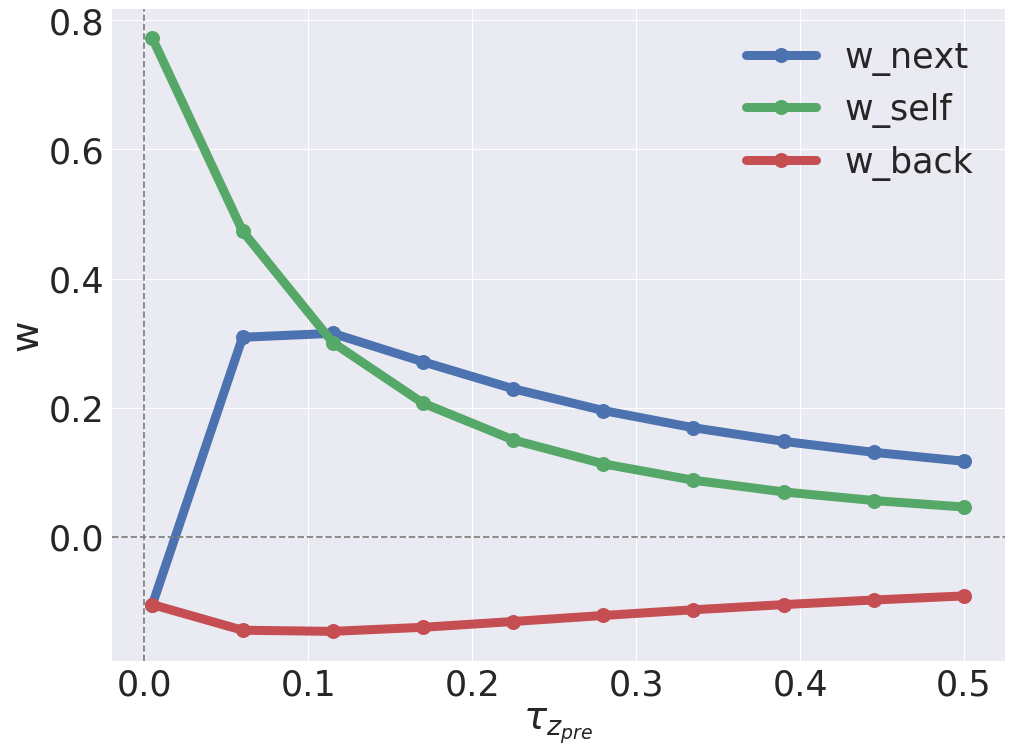

In [16]:
always_learning = True
k_perfect = True

# First we run the training protocol
g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
resting_time = 5.0
epochs = 3

from_pattern = 2
to_pattern = 3

tau_z_pre_ampa = 0.020
tau_z_post_ampa = 0.005

tau_z_pre_vector = np.linspace(0.005, 0.500, num=10)
w_next_vector = []
w_self_vector = []
w_back_vector = []

for tau_z_pre_ in tau_z_pre_vector:
    # Build the network
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, sigma=sigma, G=G,
                      tau_z_pre_ampa=tau_z_pre_, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, z_transfer=False,
                      diagonal_zero=False, strict_maximum=False, perfect=True, k_perfect=k_perfect,
                      always_learning=always_learning)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    protocol = Protocol()
    patterns_indexes = [i for i in range(n_patterns)]

    # training_time = 0.100
    protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Train
    epoch_history = manager.run_network_protocol(protocol=protocol, verbose=False)
    w_next = nn.w_ampa[to_pattern, from_pattern]
    w_self = nn.w_ampa[from_pattern, from_pattern]
    w_back = nn.w_ampa[from_pattern, to_pattern]
    
    w_next_vector.append(w_next)
    w_self_vector.append(w_self)
    w_back_vector.append(w_back)
    
linewidth = 9
markersize = 15

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.plot(tau_z_pre_vector, w_next_vector, 'o-', markersize=markersize, linewidth=linewidth, label='w_next')
ax.plot(tau_z_pre_vector, w_self_vector, 'o-', markersize=markersize, linewidth=linewidth, label='w_self')
ax.plot(tau_z_pre_vector, w_back_vector, 'o-', markersize=markersize, linewidth=linewidth, label='w_back')

ax.set_xlabel(r'$\tau_{z_{pre}}$')
ax.set_ylabel('w')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')


ax.legend();

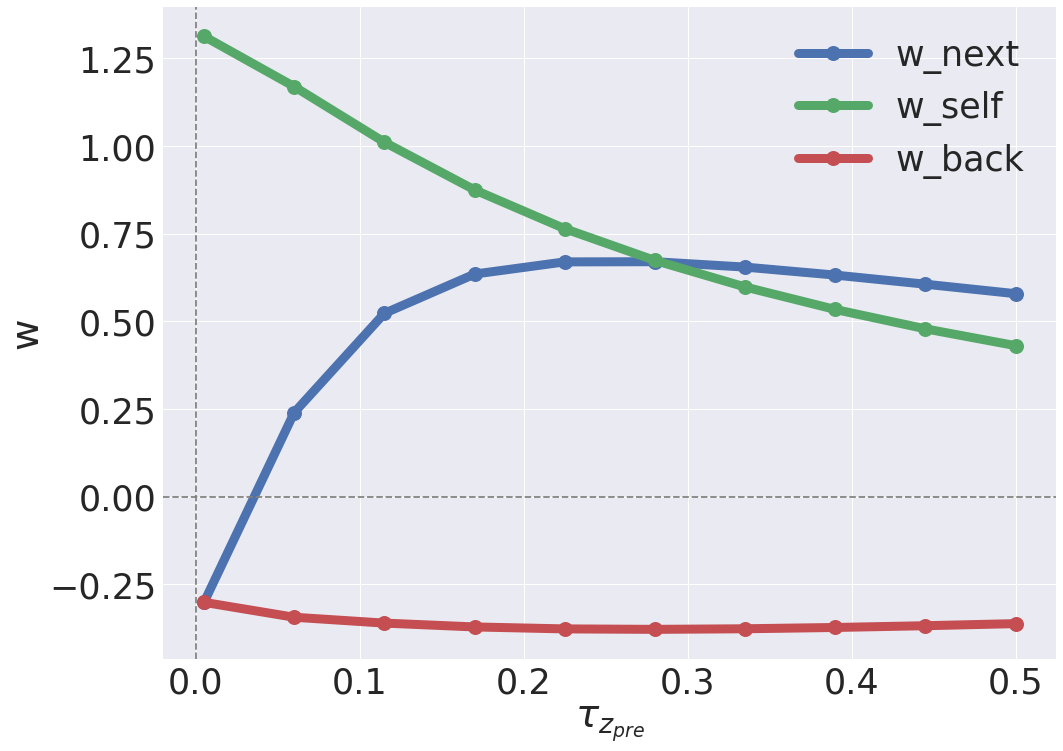

In [17]:
always_learning = True
k_perfect = True

# First we run the training protocol
g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.300
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
resting_time = 5.0
epochs = 3

from_pattern = 2
to_pattern = 3

tau_z_pre_ampa = 0.020
tau_z_post_ampa = 0.005

tau_z_pre_vector = np.linspace(0.005, 0.500, num=10)
w_next_vector = []
w_self_vector = []
w_back_vector = []

for tau_z_pre_ in tau_z_pre_vector:
    # Build the network
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, sigma=sigma, G=G,
                      tau_z_pre_ampa=tau_z_pre_, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, z_transfer=False,
                      diagonal_zero=False, strict_maximum=False, perfect=True, k_perfect=k_perfect,
                      always_learning=always_learning)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    protocol = Protocol()
    patterns_indexes = [i for i in range(n_patterns)]

    # training_time = 0.100
    protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Train
    epoch_history = manager.run_network_protocol(protocol=protocol, verbose=False)
    w_next = nn.w_ampa[to_pattern, from_pattern]
    w_self = nn.w_ampa[from_pattern, from_pattern]
    w_back = nn.w_ampa[from_pattern, to_pattern]
    
    w_next_vector.append(w_next)
    w_self_vector.append(w_self)
    w_back_vector.append(w_back)
    
linewidth = 9
markersize = 15

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.plot(tau_z_pre_vector, w_next_vector, 'o-', markersize=markersize, linewidth=linewidth, label='w_next')
ax.plot(tau_z_pre_vector, w_self_vector, 'o-', markersize=markersize, linewidth=linewidth, label='w_self')
ax.plot(tau_z_pre_vector, w_back_vector, 'o-', markersize=markersize, linewidth=linewidth, label='w_back')

ax.set_xlabel(r'$\tau_{z_{pre}}$')
ax.set_ylabel('w')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')


ax.legend();

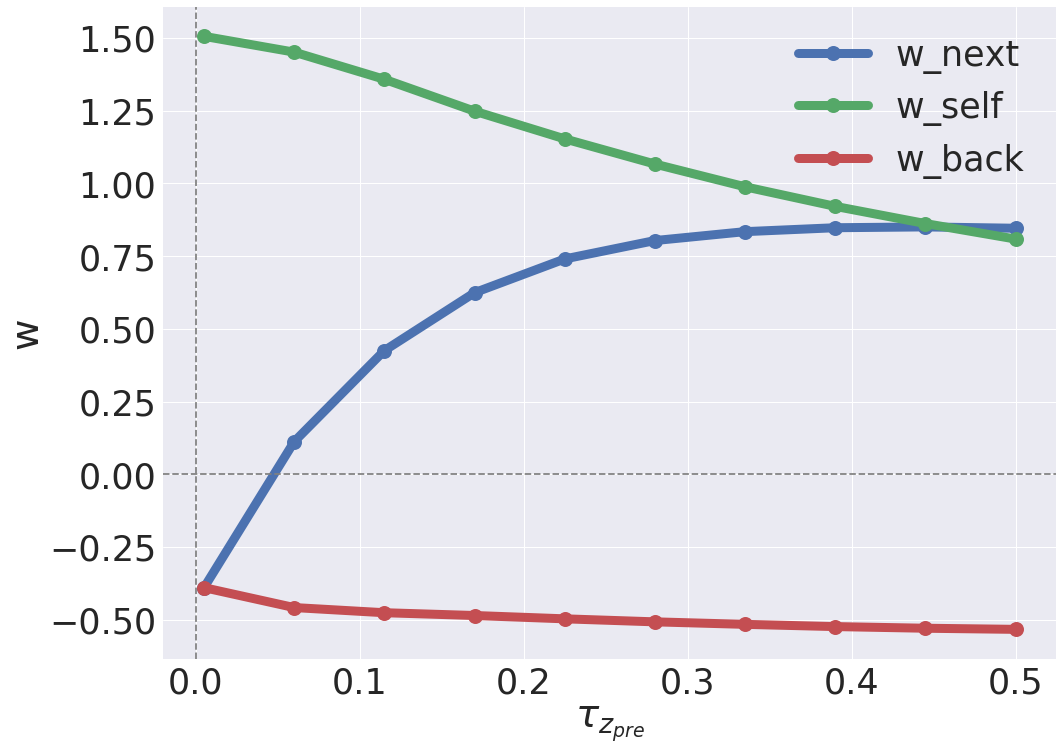

In [18]:
always_learning = True
k_perfect = True

# First we run the training protocol
g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_p = 10.0

# Patterns parameters
hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.500
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
resting_time = 5.0
epochs = 3

from_pattern = 2
to_pattern = 3

tau_z_pre_ampa = 0.020
tau_z_post_ampa = 0.005

tau_z_pre_vector = np.linspace(0.005, 0.500, num=10)
w_next_vector = []
w_self_vector = []
w_back_vector = []

for tau_z_pre_ in tau_z_pre_vector:
    # Build the network
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, sigma=sigma, G=G,
                      tau_z_pre_ampa=tau_z_pre_, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p, z_transfer=False,
                      diagonal_zero=False, strict_maximum=False, perfect=True, k_perfect=k_perfect,
                      always_learning=always_learning)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    protocol = Protocol()
    patterns_indexes = [i for i in range(n_patterns)]

    # training_time = 0.100
    protocol.simple_protocol(patterns_indexes, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                             inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Train
    epoch_history = manager.run_network_protocol(protocol=protocol, verbose=False)
    w_next = nn.w_ampa[to_pattern, from_pattern]
    w_self = nn.w_ampa[from_pattern, from_pattern]
    w_back = nn.w_ampa[from_pattern, to_pattern]
    
    w_next_vector.append(w_next)
    w_self_vector.append(w_self)
    w_back_vector.append(w_back)
    
linewidth = 9
markersize = 15

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

ax.plot(tau_z_pre_vector, w_next_vector, 'o-', markersize=markersize, linewidth=linewidth, label='w_next')
ax.plot(tau_z_pre_vector, w_self_vector, 'o-', markersize=markersize, linewidth=linewidth, label='w_self')
ax.plot(tau_z_pre_vector, w_back_vector, 'o-', markersize=markersize, linewidth=linewidth, label='w_back')

ax.set_xlabel(r'$\tau_{z_{pre}}$')
ax.set_ylabel('w')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')


ax.legend();